In [22]:
import gudhi
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import gudhi.representations
from itertools import combinations
import seaborn as sns
from gudhi.hera import wasserstein_distance
from gudhi.hera import bottleneck_distance
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp

In [23]:
def nodesExtractorC(name):
    """Extracts nodes and their corresponding information"""
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    data_structure = matlab_data['nodesC2']
    nodes_data = data_structure.squeeze()
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    return nodes_df

def edgesExtractorC(name):
    """Extracts segments to create a dataframe of from and to nodes"""
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    data_structure = matlab_data['segments']
    edges_data = data_structure.squeeze()
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    return edge_df

def nodesExtractorH(name):
    """Extracts nodes and their corresponding information"""
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    data_structure = matlab_data['nodesC3']
    nodes_data = data_structure.squeeze()
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    return nodes_df

def edgesExtractorH(name):
    """Extracts segments to create a dataframe of from and to nodes"""
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    data_structure = matlab_data['segments']
    edges_data = data_structure.squeeze()
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    return edge_df

In [24]:
def inputForGUDHI(name, direction, height,pruned):
    """
    Creates the correct data format for GUDHI to run 0-D persistence.
    
    Parameters:
    -----------
    name : str
        Dataset name
    direction : str
        'pos' for positive direction (min to max)
        'neg' for negative direction (max to min)
    height : int
        Column index for the height dimension:
        1 for X, 2 for Y, 3 for Z
    
    Returns:
    --------
    edges : list of tuples
        Edge connectivity
    node_heights : dict
        Normalized height values for each node
    """
    if pruned == 0:
        edge_df = edgesExtractorC(name)
        node_df = nodesExtractorC(name)
    elif pruned == 1:
        edge_df = edgesExtractorH(name)
        node_df = nodesExtractorH(name)
    edges = list(edge_df.iloc[:,[1,2]].itertuples(index=False, name=None))
    
    # Get the height values for the selected dimension
    height_values = node_df.iloc[:, height].values
    
    # Find min and max for normalization
    min_height = height_values.min()
    max_height = height_values.max()
    
    # Normalize heights to [0, 1] range or scale appropriately
    if direction == 'pos':
        # Positive direction: go from minimum to maximum
        normalized_heights = height_values
    elif direction == 'neg':
        # Negative direction: invert so we go from maximum to minimum
        # This effectively reverses the filtration direction
        normalized_heights = max_height + min_height - height_values
    
    node_heights = dict(zip(node_df.iloc[:,0], normalized_heights))
    
    return edges, node_heights

def count_bars(persistence):
    """
    Count the number of bars in the persistence barcode.
    
    Parameters:
    -----------
    persistence : list
        Persistence pairs from GUDHI
        Format: [(dimension, (birth, death)), ...]
    
    Returns:
    --------
    bar_counts : dict
        Dictionary with bar counts per dimension
        e.g., {0: 145, 1: 23}
    """
    bar_counts = defaultdict(int)
    
    for dim, (birth, death) in persistence:
        # Skip infinite bars (features that never die)
        if death != float('inf'):
            bar_counts[dim] += 1
    
    return dict(bar_counts)

def directional_complexity(persistence):
    """
    Calculate directional complexity as the sum of the life of each bar.
    This measures the total persistence across all features.
    
    Parameters:
    -----------
    persistence : list
        Persistence pairs from GUDHI
        Format: [(dimension, (birth, death)), ...]
    
    Returns:
    --------
    complexity : dict
        Dictionary with total persistence per dimension
        e.g., {0: 1234.5, 1: 456.7}
    """
    complexity = defaultdict(float)
    
    for dim, (birth, death) in persistence:
        # Skip infinite bars
        if death != float('inf'):
            life = death - birth
            complexity[dim] += life
    
    return dict(complexity)

def analyze_persistence(persistence, dimension=0):
    """
    Comprehensive analysis of persistence diagram.
    
    Parameters:
    -----------
    persistence : list
        Persistence pairs from GUDHI
    dimension : int
        Which homological dimension to analyze (default: 0)
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'num_bars': number of bars
        - 'complexity': sum of lifespans
        - 'avg_life': average lifespan
        - 'max_life': maximum lifespan
        - 'lifespans': list of individual lifespans
    """
    lifespans = []
    
    for dim, (birth, death) in persistence:
        if dim == dimension and death != float('inf'):
            lifespans.append(death - birth)
    
    if not lifespans:
        return {
            'num_bars': 0,
            'complexity': 0.0,
            'avg_life': 0.0,
            'max_life': 0.0,
            'lifespans': []
        }
    
    return {
        'num_bars': len(lifespans),
        'complexity': sum(lifespans),
        'avg_life': np.mean(lifespans),
        'max_life': max(lifespans),
        'lifespans': lifespans
    }

# O-D Height Filtration

Bar Counts by Dimension: {0: 450}

Directional Complexity by Dimension: {0: 151457.43584700464}

Detailed Analysis for H0:
  num_bars: 450
  complexity: 151457.43584700517
  avg_life: 336.57207966001147
  max_life: 2197.1119675062237


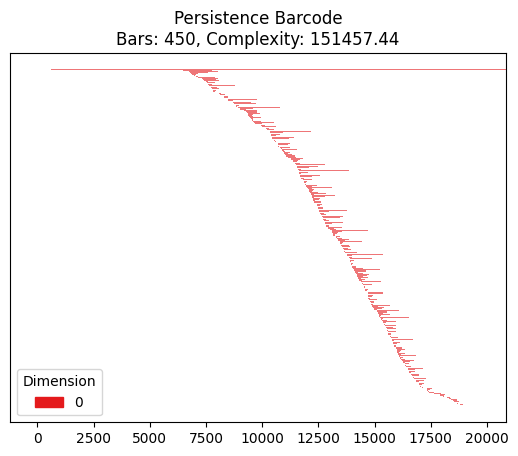

In [128]:
# Run filtration
edges, node_heights = inputForGUDHI('m1p1_060107', 'pos', 3,1)  # Z-axis, positive direction

st = gudhi.SimplexTree()

# Add vertices assigned to their height as the filtration value
for node, height in node_heights.items():
    st.insert([node], filtration=height)

# Add edges with the maximum height as filtration value
for u, v in edges:
    filt_value = max(node_heights[u], node_heights[v])
    st.insert([u, v], filtration=filt_value)

st.make_filtration_non_decreasing()
st.compute_persistence()

# Get persistence
persistence = st.persistence()

# Analyze
bar_counts = count_bars(persistence)
complexity = directional_complexity(persistence)
detailed_analysis = analyze_persistence(persistence, dimension=0)

print("Bar Counts by Dimension:", bar_counts)
print("\nDirectional Complexity by Dimension:", complexity)
print("\nDetailed Analysis for H0:")
for key, value in detailed_analysis.items():
    if key != 'lifespans':
        print(f"  {key}: {value}")

# Plot
gudhi.plot_persistence_barcode(persistence)
plt.title(f'Persistence Barcode\nBars: {bar_counts.get(0, 0)}, Complexity: {complexity.get(0, 0):.2f}')
plt.show()

<Axes: title={'center': 'Persistence barcode'}>

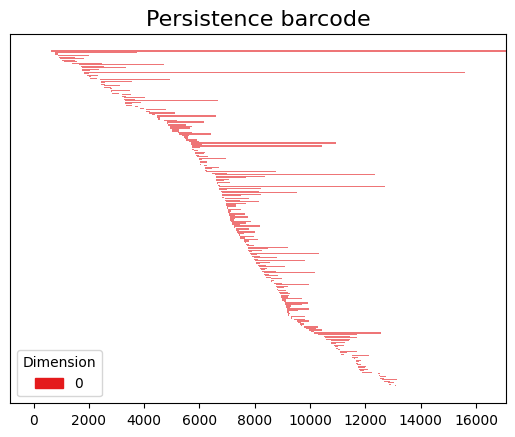

In [75]:
edges,node_heights = inputForGUDHI('m1p4_053007','neg',3,1)

st = gudhi.SimplexTree()

#adds vertices assigned to their height as the filtration value
for node,height in node_heights.items():
    st.insert([node],filtration=height)

#adds edges with the maximum height as filtration value
for u,v in edges:
    filt_value = max(node_heights[u],node_heights[v])
    st.insert([u,v],filtration=filt_value)

st.make_filtration_non_decreasing()

st.compute_persistence()
gudhi.plot_persistence_barcode(st.persistence())

<Axes: title={'center': 'Persistence barcode'}>

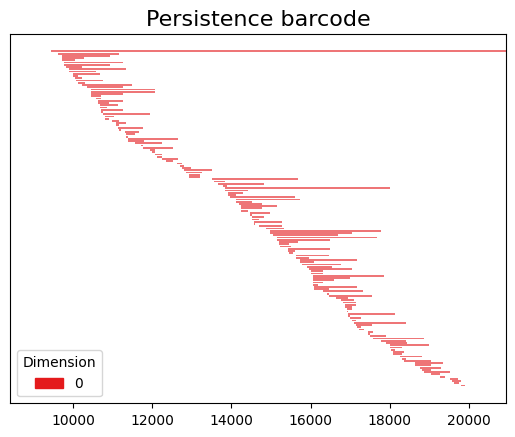

In [ ]:
edges,node_heights = inputForGUDHI('m2p4_060407','pos',1)

st = gudhi.SimplexTree()

#adds vertices assigned to their height as the filtration value
for node,height in node_heights.items():
    st.insert([node],filtration=height)

#adds edges with the maximum height as filtration value
for u,v in edges:
    filt_value = max(node_heights[u],node_heights[v])
    st.insert([u,v],filtration=filt_value)

st.make_filtration_non_decreasing()

st.compute_persistence()
gudhi.plot_persistence_barcode(st.persistence())